In [1]:
import utilities as utils


    Last Execution: 2022-04-02 19:47:09.777505
    python:	3.9.11

    	fastai:		2.5.6
    	matplotlib:	3.5.1
    	numpy:		1.19.2
    	pandas:		1.4.1
    	seaborn:	0.11.2
    	sklearn:	1.0.2
    	torch:		1.11.0
    	yellowbrick:	1.3
    	imbalanced learn:	0.9.0
    


/home/drake/miniconda3/envs/fastai/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# This code is used to scale to processing numerous datasets
data_path_1: str = '../../../Data/phase1/'   

data_set_1: list = [ 'Darknet_reduced_features.csv' ]

data_set: list  = data_set_1
file_path_1      = utils.get_file_path(data_path_1)
file_set: list   = list(map(file_path_1, data_set_1))
current_job: int = 0

utils.data_set = data_set
utils.file_set = file_set



In [3]:
print(f'We will be cleaning {len(file_set)} files:')
utils.pretty(file_set)

We will be cleaning 1 files:
[   '../../../Data/phase1/Darknet_reduced_features.csv']


## Label Analysis

Now we load the data and separate the dataset by label, giving us a traffic dataset and an application dataset. We also want to investigate how merging the Non-Tor and NonVNP labels together affects the clustering, so rename the samples under these labels as regular and produce a second traffic dataset with it.

In [4]:

dataset           : dict = utils.examine_dataset(1)
#dataset_2            : dict = utils.copy.deepcopy(dataset_1)
#dataset_2['Dataset'] = dataset_1['Dataset'][dataset_1['Dataset']['Traffic Type'] != 'NonVPN']
dataset            : dict = utils.package_data_for_inspection_with_label(
                                    utils.reduce_feature_to_values(dataset['Dataset'], 'Traffic Type', ['Tor', 'VPN', 'Non-Tor'] ), 'Dataset_2')
dataset['Dataset'] = utils.rename_values_in_column(dataset, [('Traffic Type', {'Non-Tor': 'Regular'})])

#traffic_dataset_1    : dict = utils.package_data_for_inspection_with_label(utils.prune_dataset(dataset_1, ['Application Type']), 'Traffic_Dataset_1_Tor_VPN_Non_Tor_NonVPN')
traffic_dataset    : dict = utils.package_data_for_inspection_with_label(utils.prune_dataset(dataset, ['Application Type']),
                                                                           'Traffic_Dataset_2_Tor_VPN_Regular')
application_dataset: dict = utils.package_data_for_inspection_with_label(utils.prune_dataset(dataset, ['Traffic Type']), 
                                                                           'Application_Dataset_1')

Dataset 1/1: We now look at ../../../Data/phase1/Darknet_reduced_features.csv


Loading Dataset: ../../../Data/phase1/Darknet_reduced_features.csv
	To Dataset Cache: ./cache/Darknet_reduced_features.csv.pickle


        File:				../../../Data/phase1/Darknet_reduced_features.csv  
        Job Number:			1
        Shape:				(141481, 64)
        Samples:			141481 
        Features:			64
    


/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:600: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())
/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:600: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())
/home/drake/projects/Sp22/CMUDarknet/experiments/data_generation/SMOTE/utilities.py:600: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(df[df[column] == v].copy())



        Shape:				(117620, 64)
        Samples:			117620 
        Features:			64
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    

        Shape:				(117620, 63)
        Samples:			117620 
        Features:			63
    


# SMOTE Prototype

Here we load up our first SMOTE and train it on the whole traffic dataset. This way we have some data to play around with and can go about devising an augmentation strategy for the experiment process.

In [5]:
def get_x_and_y(df: utils.pd.DataFrame, target_label: str) -> tuple:
    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    categorical_features: list = []

    if 'Protocol' in df.columns:
        categorical_features.append("Protocol")
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=0.2, seed=utils.seed)(utils.range_of(df))

    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)


    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()
    
    #X_train = X_train.append(X_test)
    #y_train = np.append(y_train,y_test)
    return X_train, y_train

def create_and_visualize_smote(df: utils.pd.DataFrame, target_label: str, ratio_dict: dict) -> list:
    X = df.drop(target_label, axis=1)
    y = df[target_label]
    model = utils.SMOTE(sampling_strategy=ratio_dict)
    X, y = model.fit_resample(X, y)
    counter = utils.Counter(y)
    for k,v in counter.items():
        per = v / len(y) * 100
        print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
    # plot the distribution
    utils.pyplot.bar(counter.keys(), counter.values())
    utils.pyplot.show()
    return utils.pd.concat([X, utils.pd.DataFrame(y)], axis=1)

def get_largest_class_sample_size(df: utils.pd.DataFrame, column_name: str) -> int:
    '''
        Function returns the largest class sample size
    '''
    #X, y = get_x_and_y(df, column_name)
    #y = pd.DataFrame(pd.DataFrame(y))
    return df.groupby(column_name).size().max()



Class=Tor, n=93309 (33.333%)
Class=VPN, n=93309 (33.333%)
Class=Regular, n=93309 (33.333%)


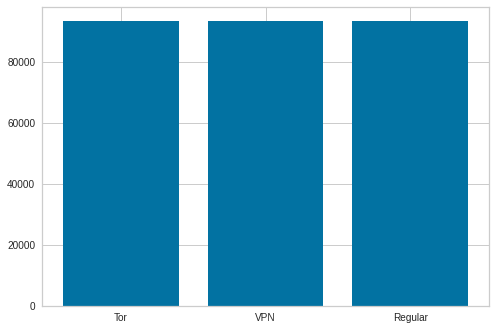

In [6]:
largest_class = get_largest_class_sample_size(traffic_dataset['Dataset'], 'Traffic Type')
ratio_dict = {"VPN": largest_class, "Regular": largest_class, "Tor": largest_class}
fake_df_traffic = create_and_visualize_smote(traffic_dataset['Dataset'], 'Traffic Type', ratio_dict)

Class=audio-streaming, n=48520 (12.500%)
Class=browsing, n=48520 (12.500%)
Class=chat, n=48520 (12.500%)
Class=file-transfer, n=48520 (12.500%)
Class=email, n=48520 (12.500%)
Class=p2p, n=48520 (12.500%)
Class=video-streaming, n=48520 (12.500%)
Class=voip, n=48520 (12.500%)


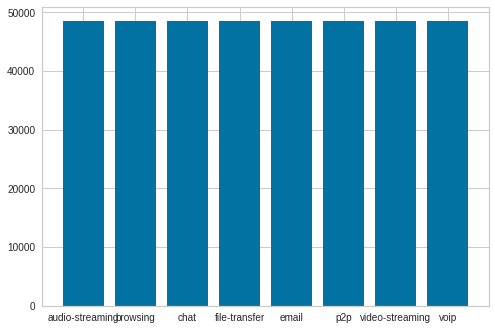

In [7]:
largest_class = get_largest_class_sample_size(application_dataset['Dataset'], 'Application Type')
ratio_dict = {"audio-streaming": largest_class, "browsing": largest_class, "chat": largest_class, "email": largest_class, "file-transfer": largest_class, "p2p": largest_class, "video-streaming": largest_class, "voip": largest_class}
fake_df_application = create_and_visualize_smote(application_dataset['Dataset'], 'Application Type', ratio_dict)

In [8]:
fake_traffic_dataset: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic), [] ), 
    'Fake_Traffic_Dataset_1_Tor_VPN_Non_Tor_NonVPN'
)

fake_application_dataset: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_application), [] ), 
    'Fake_Traffic_Dataset_3_Application_Dataset'
)


    Dataset statistics:
        Shape:				(279927, 63)
        Samples:			279927 
        Features:			63
    

        Shape:				(279927, 63)
        Samples:			279927 
        Features:			63
    

    Dataset statistics:
        Shape:				(388160, 63)
        Samples:			388160 
        Features:			63
    

        Shape:				(388160, 63)
        Samples:			388160 
        Features:			63
    


In [9]:
def run_deep_nn_experiment(df: utils.pd.DataFrame, name: str, target_label: str, shape: tuple) -> tuple:
    '''
        Run binary classification on a given dataframe, saving the model as {name}.model
        returns the 7-tuple with the following indicies:
        viz_data: tuple = (name, model, classes, X_train, y_train, X_test, y_test)
    '''

    # First we split the features into the dependent variable and 
    # continous and categorical features
    dep_var: str = target_label

    assert len(shape) == 2, 'Shape must be a tuple of length 2'

    categorical_features: list = []
    # categorical_features: list = ['Application Type']

    print(df.shape)

    if 'Protocol' in df.columns:
        categorical_features.append("Protocol")
        
    continuous_features = list(set(df) - set(categorical_features) - set([dep_var]))

    # Next, we set up the feature engineering pipeline, namely filling missing values
    # encoding categorical features, and normalizing the continuous features
    # all within a pipeline to prevent the normalization from leaking details
    # about the test sets through the normalized mapping of the training sets
    procs = [utils.FillMissing, utils.Categorify, utils.Normalize]
    splits = utils.RandomSplitter(valid_pct=0.2, seed=utils.seed)(utils.range_of(df))
    
    # The dataframe is loaded into a fastai datastructure now that 
    # the feature engineering pipeline has been set up
    to = utils.TabularPandas(
        df            , y_names=dep_var                , 
        splits=splits , cat_names=categorical_features ,
        procs=procs   , cont_names=continuous_features , 
    )

    # The dataframe is then converted into a fastai dataset
    dls = to.dataloaders(bs=64)

    # extract the name from the path
    p = utils.pathlib.Path(name)
    name: str = str(p.parts[-1])


    # Next, we set up, train, and save the deep neural network
    model = utils.tabular_learner(dls, layers=[100, 60], metrics=utils.accuracy, cbs=utils.ShowGraphCallback)
    model.fit_one_cycle(10)
    model.save(f'{name}.model')
    model._description = f'fastai_{name}_model'
    
    # We print the results of the training    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))
    preds,y, loss = model.get_preds(with_loss=True)
    probs = utils.np.exp(preds[:,1])
    
   
    # Compute ROC curve
    fpr, tpr, thresholds = utils.roc_curve(y, probs, pos_label=1)
    # Compute ROC area
    roc_auc = utils.auc(fpr, tpr)
    print('The AUC is {0}'.format(roc_auc))
    
    
    # Plot of a ROC curve for a specific class
    # A confusion matrix is created to help evaluate the results
    interp = utils.ClassificationInterpretation.from_learner(model)
    interp.plot_confusion_matrix()
    interp.print_classification_report()

    # We extract the training and test datasets from the dataframe
    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()
    
    
    # We wrap our model to make it look like a scikitlearn model
    # for visualization using yellowbrick
    wrapped_model = utils.SklearnWrapper(model)
    wrapped_model._description = f'wrapped_{name}_model'
    # we add a target_type_ attribute to our model so yellowbrick knows how to make the visualizations
    classes = list(model.dls.vocab)
    if len(classes) == 2:
        wrapped_model.target_type_ = 'binary'
    elif len(classes) > 2:  
        wrapped_model.target_type_ = 'multiclass'
    else:
        print('Must be more than one class to perform classification')
        raise ValueError('Wrong number of classes')
    
    wrapped_model._target_labels = dep_var
    
    # Now that the classifier has been created and trained, we pass out our training values
    # so that yellowbrick can use them to create various visualizations
    viz_data: tuple = (name, wrapped_model, classes, X_train, y_train, X_test, y_test)

    return viz_data

In [10]:
results = run_deep_nn_experiment(
    fake_traffic_dataset['Dataset'], 
    'file.file.csv', 
    'Traffic Type', 
    (100, 50))

(279927, 63)


epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
fake_traffic_dataset['Dataset'].to_csv('./synthetic/smote/smote_balanced_traffic_dataset_labels_equal.csv', index=False)
fake_application_dataset['Dataset'].to_csv('./synthetic/smote/smote_balanced_application_dataset_labels_equal.csv', index=False)

20,000 Regular, 15,000 VPN, 5,000 Tor

In [ ]:
def create_and_filter_new_model(model: utils.Model_data, column_name: str, value: str, prune_column: str = None) -> utils.Model_data:
    '''
        Function returns a new model with the given column name and value
    '''
    new_model : dict = utils.copy.deepcopy(model)
    new_model['Dataset'] = model["Dataset"][model["Dataset"][column_name] == value]

    if prune_column is not None:
        new_model['Dataset'] = utils.prune_dataset(new_model, [prune_column])
    return new_model

def downsample(df: utils.pd.DataFrame, column_name: str, size : int) -> utils.pd.DataFrame:
    '''
        Function returns a new dataframe with the given column name and value
    '''
    return df.groupby(column_name, group_keys=False).apply(lambda df: df.sample(size))


In [ ]:
vpn : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'VPN')
tor : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Tor')
regular : utils.Model_data = create_and_filter_new_model(traffic_dataset, 'Traffic Type', 'Regular')

In [66]:
regular['Dataset']  = downsample(regular['Dataset'], 'Traffic Type', 20000)
vpn['Dataset']  = downsample(vpn['Dataset'], 'Traffic Type', 15000)

Class=Regular, n=20000 (50.000%)
Class=VPN, n=15000 (37.500%)
Class=Tor, n=5000 (12.500%)


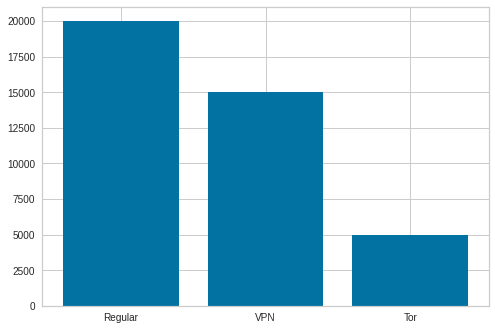

In [69]:
ratio_dict = {"VPN": 15000, "Regular": 20000, "Tor": 5000}
fake_df_traffic_2 = create_and_visualize_smote(utils.pd.concat([regular['Dataset'],vpn['Dataset'],tor['Dataset']]), 'Traffic Type', ratio_dict)

In [70]:
fake_traffic_dataset_2: dict = utils.package_data_for_inspection_with_label(
    utils.prune_dataset(utils.package_data_for_inspection(fake_df_traffic_2), [] ), 
    'Fake_Traffic_Dataset_2_20_15_5'
)



    Dataset statistics:
        Shape:				(40000, 63)
        Samples:			40000 
        Features:			63
    

        Shape:				(40000, 63)
        Samples:			40000 
        Features:			63
    


In [76]:
fake_traffic_dataset_2['Dataset'].to_csv('./synthetic/smote/smote_balanced_traffic_dataset_labels_20_15_5.csv', index=False)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,0.388053,0.318265,0.894875,0.863181,0.959450,0.821108,0.878554,0.897820,0.863181,00:09
1,0.282895,0.251620,0.920250,0.887757,0.960600,0.865281,0.906229,0.932764,0.887757,00:08
2,0.245351,0.353621,0.851750,0.850225,0.958638,0.771976,0.860470,0.898397,0.850225,00:08
3,0.236015,0.300696,0.945625,0.923684,0.979288,0.909852,0.935506,0.952575,0.923684,00:08
4,0.175321,0.151661,0.964750,0.936150,0.983955,0.940301,0.949922,0.966728,0.936150,00:08
5,0.177324,0.573605,0.577250,0.657684,0.948640,0.445988,0.622513,0.791990,0.657684,00:08
6,0.166248,0.200963,0.959000,0.930581,0.980799,0.930870,0.945436,0.964691,0.930581,00:08
7,0.137652,0.174824,0.963875,0.933111,0.982859,0.939002,0.949231,0.970097,0.933111,00:08
8,0.146427,0.219449,0.959000,0.931904,0.980085,0.930905,0.945842,0.963746,0.931904,00:08
9,0.132660,0.211544,0.961375,0.933547,0.982382,0.934978,0.947377,0.965201,0.933547,00:08


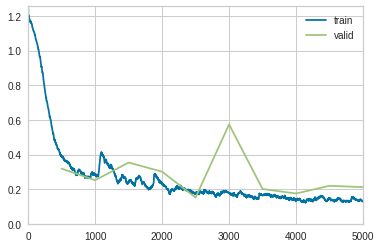

loss: 0.2115439623594284, accuracy:  96.14%


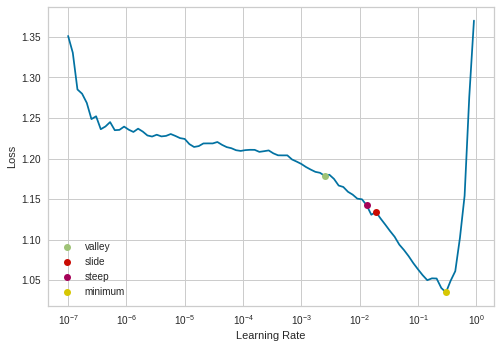

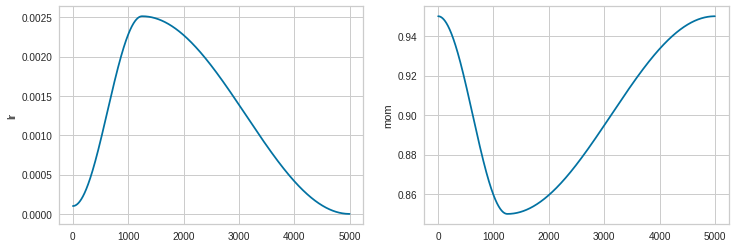

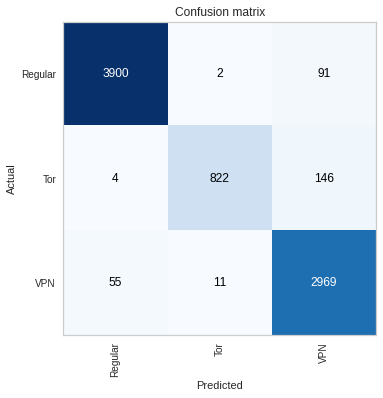

In [77]:
results = utils.run_deep_nn_experiment(
    fake_traffic_dataset_2['Dataset'], 
    'file.file.csv', 
    'Traffic Type', 
    (100 for i in range(20)),
    epochs=10
)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,roc_auc_score,matthews_corrcoef,f1_score,precision_score,recall_score,time
0,0.200787,0.381383,0.887817,0.738071,0.944257,0.662226,0.783877,0.873046,0.738071,00:26
1,0.142956,0.121152,0.967735,0.632915,0.962679,0.899190,0.635324,0.638119,0.632915,00:25
2,0.087665,0.097346,0.979425,0.800774,0.979601,0.936476,0.855715,0.953418,0.800774,00:24
3,0.073622,0.063744,0.986439,0.921140,0.991864,0.958398,0.929235,0.937717,0.921140,00:24
4,0.076694,0.093750,0.980658,0.756019,0.984846,0.940617,0.792089,0.873986,0.756019,00:24
5,0.054254,0.094613,0.983421,0.886267,0.993283,0.949010,0.907503,0.931650,0.886267,00:24
6,0.052436,0.081679,0.979425,0.686753,0.988363,0.936344,0.705604,0.756256,0.686753,00:24
7,0.050442,0.627786,0.977767,0.676296,0.989312,0.931099,0.695032,0.768727,0.676296,00:25
8,0.037811,0.613564,0.980786,0.669248,0.982850,0.940626,0.677716,0.732027,0.669248,00:25
9,0.040964,0.330509,0.980786,0.671580,0.987428,0.940616,0.681946,0.743061,0.671580,00:25


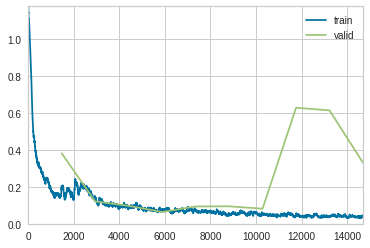

/home/drake/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



loss: 0.33050858974456787, accuracy:  98.08%


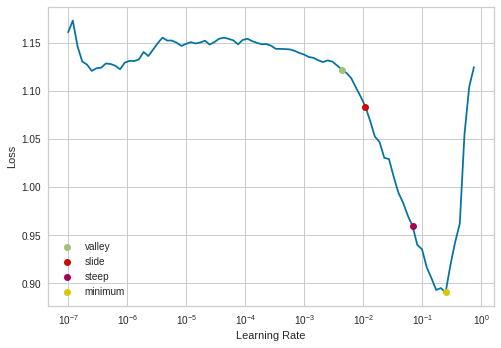

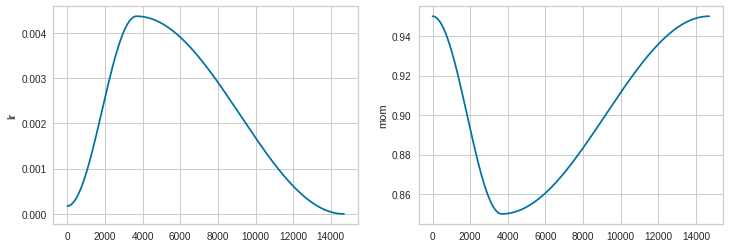

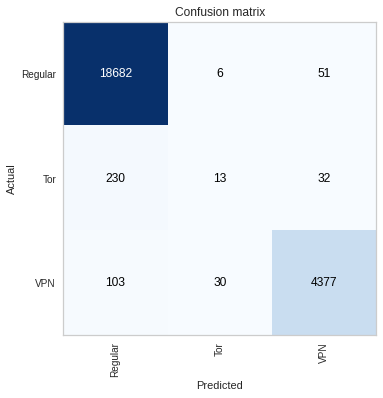

In [79]:
results = utils.run_deep_nn_experiment(
    orig['Dataset'], 
    'file.file.csv', 
    'Traffic Type', 
    (100 for i in range(20)),
    epochs=10
)

In [13]:
print(f'Last Execution: {utils.datetime.datetime.now()}')
assert False, 'Nothing after this point is included in the study'

Last Execution: 2022-03-29 19:45:34.423160


AssertionError: Nothing after this point is included in the study